In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mujoco
import mujoco_viewer
import openai
import cv2,os
import sys
import argparse
import re
print ("openai version:[%s]"%(openai.__version__))

def extract_number(filename):
    # Extract the number from the filename using regular expression
    match = re.search(r'(\d+)', filename)
    return int(match.group()) if match else float('inf')


openai version:[1.3.8]


In [2]:
#%%
import math
from matplotlib import gridspec
import matplotlib.pyplot as plt
import numpy as np
import urllib.request
from PIL import Image
import io
import re
import copy
import os
import cv2
import base64
from io import BytesIO
import requests
import openai
from tenacity import retry, stop_after_attempt, wait_fixed
from IPython.display import Markdown,display
from rich.console import Console
import json
import os
import sys

#%%
def extract_number(filename):
    # Extract the number from the filename using regular expression
    match = re.search(r'(\d+)', filename)
    return int(match.group()) if match else float('inf')

def response_to_json(response):
    # Remove the markdown code block formatting
    response_strip = response.strip('```json\n').rstrip('```')
    # Convert the cleaned string to a JSON object
    try:
        response_json = json.loads(response_strip)
    except json.JSONDecodeError as e:
        response_json = None
        error_message = str(e)

    return response_json, error_message if response_json is None else ""

def set_openai_api_key_from_txt(key_path='./key.txt',VERBOSE=True):
    """
        Set OpenAI API Key from a txt file
    """
    with open(key_path, 'r') as f: 
        OPENAI_API_KEY = f.read()
    openai.api_key = OPENAI_API_KEY
    if VERBOSE:
        print ("OpenAI API Key Ready from [%s]."%(key_path))

def visualize_subplots(images, cols=3):
    """
    Visualize a list of images.

    Parameters:
    images (list): List of images. Each image can be a path to an image file or a numpy array.
    cols (int): Number of columns in the image grid.
    """
    imgs_to_show = []

    # Load images if they are paths, or directly use them if they are numpy arrays
    for img in images:
        if isinstance(img, str):  # Assuming it's a file path
            img_data = plt.imread(img)
        elif isinstance(img, np.ndarray):  # Assuming it's a numpy array
            img_data = img
        else:
            raise ValueError("Images should be either file paths or numpy arrays.")
        imgs_to_show.append(img_data)

    N = len(imgs_to_show)
    if N == 0:
        print("No images to display.")
        return

    rows = int(math.ceil(N / cols))
    gs = gridspec.GridSpec(rows, cols)
    fig = plt.figure(figsize=(cols * 4, rows * 4))

    for n in range(N):
        ax = fig.add_subplot(gs[n])
        ax.imshow(imgs_to_show[n])
        ax.set_title(f"Image {n + 1}")
        ax.axis('off')

    fig.tight_layout()
    plt.show()

class GPT4VisionClass:
    def __init__(
            self, 
            gpt_model: str = "gpt-4-vision-preview",
            role_msg: str = "You are a helpful agent with vision capabilities; do not respond to objects not depicted in images.",
            key_path='../key/rilab_key.txt', 
            max_tokens = 512, temperature = 0.9, n = 1, stop = [], VERBOSE=True,
            image_max_size:int = 512,
            ):
        self.gpt_model = gpt_model
        self.role_msg = role_msg
        self.messages = [{"role": "system", "content": f"{role_msg}"}]
        self.init_messages = [{"role": "system", "content": f"{role_msg}"}]
        self.history = [{"role": "system", "content": f"{role_msg}"}]
        self.image_max_size = image_max_size

        # GPT-4 parameters
        self.max_tokens = max_tokens
        self.temperature = temperature
        self.n = n
        self.stop = stop
        self.VERBOSE = VERBOSE
        if self.VERBOSE:
            self.console = Console()
        self.response = None
        self.image_token_count = 0

        self._setup_client(key_path)

    def _setup_client(self, key_path):
        if self.VERBOSE:
            self.console.print(f"[bold cyan]key_path:[%s][/bold cyan]" % (key_path))

        with open(key_path, "r") as f:
            OPENAI_API_KEY = f.read()
        self.client = openai.OpenAI(api_key=OPENAI_API_KEY)

        if self.VERBOSE:
            self.console.print(
                "[bold cyan]Chat agent using [%s] initialized with the follow role:[%s][/bold cyan]"
                % (self.gpt_model, self.role_msg)
            )
    
    def _backup_chat(self):
        self.init_messages = copy.copy(self.messages)

    def _get_response_content(self):
        if self.response:
            return self.response.choices[0].message.content
        else:
            return None

    def _get_response_status(self):
        if self.response:
            return self.response.choices[0].message.finish_reason
        else:
            return None
        
    def _encode_image_path(self, image_path):
        # with open(image_path, "rb") as image_file:
        image_pil = Image.open(image_path)
        image_pil.thumbnail(
            (self.image_max_size, self.image_max_size)
        )
        image_pil_rgb = image_pil.convert("RGB")
        # change pil to base64 string
        img_buf = io.BytesIO()
        image_pil_rgb.save(img_buf, format="PNG")
        return base64.b64encode(img_buf.getvalue()).decode('utf-8')

    def _encode_image(self, image):
        """
            Save the image to a temporary file and encode it to base64
        """
        # save Image:PIL to temp file
        cv2.imwrite("temp.jpg", np.array(image))
        with open("temp.jpg", "rb") as image_file:
            encoded_image = base64.b64encode(image_file.read()).decode('utf-8')
        os.remove("temp.jpg")
        return encoded_image

    def _count_image_tokens(self, width, height):
        h = math.ceil(height / 512)
        w = math.ceil(width / 512)
        n = w * h
        total = 85 + 170 * n
        return total

    def set_common_prompt(self, common_prompt):
        self.messages.append({"role": "system", "content": common_prompt})

    # @retry(stop=stop_after_attempt(10), wait=wait_fixed(5))
    def chat(
            self, 
            query_text, 
            image_paths=[], images=None, APPEND=True,
            PRINT_USER_MSG=True,
            PRINT_GPT_OUTPUT=True,
            RESET_CHAT=False,
            RETURN_RESPONSE=True,
            MAX_TOKENS = 512,
            VISUALIZE = False,
            DETAIL = "auto",
            CROP = None,
            ):
        """
            image_paths: list of image paths
            images: list of images
            You can only provide either image_paths or image.
        """
        if DETAIL:
            self.console.print(f"[bold cyan]DETAIL:[/bold cyan] {DETAIL}")
            self.detail = DETAIL
        content = [{"type": "text", "text": query_text}]
        content_image_not_encoded = [{"type": "text", "text": query_text}]
        # Prepare the history temp
        if image_paths is not None:
            local_imgs = []
            for image_path_idx, image_path in enumerate(image_paths):
                with Image.open(image_path) as img:
                    width, height = img.size
                    if CROP:
                        img = img.crop(CROP)
                        width, height = img.size
                        # convert PIL to numpy array
                        local_imgs.append(np.array(img))
                    self.image_token_count += self._count_image_tokens(width, height)

                print(f"[{image_path_idx}/{len(image_paths)}] image_path: {image_path}")
                base64_image = self._encode_image_path(image_path)
                image_content = {
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/jpeg;base64,{base64_image}",
                            "detail": self.detail
                        }
                    }
                image_content_in_numpy_array = {
                        "type": "image_numpy",
                        "image": np.array(Image.open(image_path))
                    }
                content.append(image_content)
                content_image_not_encoded.append(image_content_in_numpy_array)
        elif images is not None:
            local_imgs = []
            for image_idx, image in enumerate(images):
                image_pil = Image.fromarray(image)
                if CROP:
                    image_pil = image_pil.crop(CROP)
                    local_imgs.append(image_pil)
                    # width, height = image_pil.size
                image_pil.thumbnail(
                    (self.image_max_size, self.image_max_size)
                )
                width, height = image_pil.size
                self.image_token_count += self._count_image_tokens(width, height)
                self.console.print(f"[deep_sky_blue3][{image_idx+1}/{len(images)}] Image provided: [Original]: {image.shape}, [Downsize]: {image_pil.size}[/deep_sky_blue3]")
                base64_image = self._encode_image(image_pil)
                image_content = {
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/jpeg;base64,{base64_image}",
                            "detail": self.detail
                        }
                    }
                image_content_in_numpy_array = {
                        "type": "image_numpy",
                        "image": image
                    }
                content.append(image_content)
                content_image_not_encoded.append(image_content_in_numpy_array)
        else:
            self.console.print("[bold red]Neither image_paths nor images are provided.[/bold red]")

        if VISUALIZE:
            if image_paths:
                self.console.print("[deep_sky_blue3][VISUALIZE][/deep_sky_blue3]")
                if CROP:
                    visualize_subplots(local_imgs)
                else:
                    visualize_subplots(image_paths)
            elif images:
                self.console.print("[deep_sky_blue3][VISUALIZE][/deep_sky_blue3]")
                if CROP:
                    local_imgs = np.array(local_imgs)
                    visualize_subplots(local_imgs)
                else:
                    visualize_subplots(images)

        self.messages.append({"role": "user", "content": content})
        self.history.append({"role": "user", "content": content_image_not_encoded})
        payload = self.create_payload(model=self.gpt_model)
        self.response = self.client.chat.completions.create(**payload)

        if PRINT_USER_MSG:
            self.console.print("[deep_sky_blue3][USER_MSG][/deep_sky_blue3]")
            print(query_text)
        if PRINT_GPT_OUTPUT:
            self.console.print("[spring_green4][GPT_OUTPUT][/spring_green4]")
            print(self._get_response_content())
        # Reset
        if RESET_CHAT:
            self.messages = self.init_messages
        # Return
        if RETURN_RESPONSE:
            return self._get_response_content()

    @retry(stop=stop_after_attempt(10), wait=wait_fixed(5))
    def chat_multiple_images(self, image_paths, query_text, model="gpt-4-vision-preview", max_tokens=300):
        messages = [
            {
                "role": "user",
                "content": [{"type": "text", "text": query_text}]
            }
        ]
        for image_path in image_paths:
            base64_image = self._encode_image(image_path)
            messages[0]["content"].append(
                {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"}}
            )
        response = self.client.chat.completions.create(
            model=model,
            messages=messages,
            max_tokens=max_tokens
        )
        return response

    @retry(stop=stop_after_attempt(10), wait=wait_fixed(5))
    def generate_image(self, prompt, size="1024x1024", quality="standard", n=1):
        response = self.client.images.generate(
            model="dall-e-3",
            prompt=prompt,
            size=size,
            quality=quality,
            n=n
        )
        return response

    def visualize_image(self, image_response):
        image_url = image_response.data[0].url
        # Open the URL and convert the image to a NumPy array
        with urllib.request.urlopen(image_url) as url:
            img = Image.open(url)
            img_array = np.array(img)

        plt.imshow(img_array)
        plt.axis('off')
        plt.show()

    def create_payload(self,model):
        payload = {
            "model": model,
            "messages": self.messages,
            "max_tokens": self.max_tokens,
            "temperature": self.temperature,
            "n": self.n
        }
        if len(self.stop) > 0:
            payload["stop"] = self.stop
        return payload
    
    def save_interaction(self, data, file_path: str = "./scripts/interaction_history.json"):
        """
        Save the chat history to a JSON file.
        The history includes the user role, content, and images stored as NumPy arrays.
        """
        self.history = data.copy()
        history_to_save = []
        for entry in self.history:
            entry_to_save = {
                "role": entry["role"],
                "content": []
            }
            # Check if 'content' is a string or a list
            if isinstance(entry["content"], str):
                entry_to_save["content"].append({"type": "text", "text": entry["content"]})
            elif isinstance(entry["content"], list):
                for content in entry["content"]:
                    if content["type"] == "text":
                        entry_to_save["content"].append(content)
                    elif content["type"] == "image_numpy":
                        entry_to_save["content"].append({"type": "image_numpy", "image": content["image"].tolist()})
                    elif content["type"] == "image_url":
                        entry_to_save["content"].append(content)
            history_to_save.append(entry_to_save)
        with open(file_path, "w") as file:
            json.dump(history_to_save, file, indent=4)

        if self.VERBOSE:
            self.console.print(f"[bold green]Chat history saved to {file_path}[/bold green]")

    def get_total_token(self):
        """
            Get total token used
        """
        if self.VERBOSE:
            self.console.print(f"[bold cyan]Total token used: {self.response.usage.total_tokens}[/bold cyan]")
        return self.response.usage.total_tokens
    
    def get_image_token(self):
        """
            Get image token used
        """
        if self.VERBOSE:
            self.console.print(f"[bold cyan]Image token used: {self.image_token_count}[/bold cyan]")
        return self.image_token_count

    def reset_tokens(self):
        """
            Reset total and image token used
        """
        self.response.usage.total_tokens = 0
        self.image_token_count = 0
        if self.VERBOSE:
            self.console.print(f"[bold cyan]Image token reset[/bold cyan]")

key_path:[../key/rilab_key.txt]

Chat agent using  initialized with the follow role:[You are a helpful agent with vision capabilities; do not 
respond to objects not depicted in images.]

 [System prompt: infrom the format of the answer] 
['1.png', '2.png', '3.png', '4.png'] 4
../dataset/household/type/4/1.png
../dataset/household/type/4/2.png
../dataset/household/type/4/3.png
../dataset/household/type/4/4.png


DETAIL: high

[0/2] image_path: ../dataset/household/type/4/1.png
[1/2] image_path: ../dataset/household/type/4/2.png


[VISUALIZE]

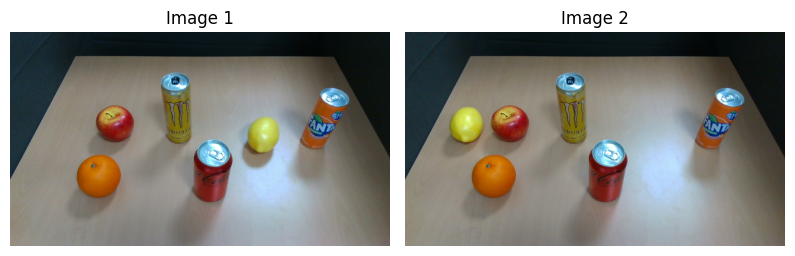

[USER_MSG]


    I will give you <img_1> and <img_2>.
    How did the objects move between the two images? start from the <img_1> into <img_2>?
    only using the following object names: ['apple', 'lemon', 'orange', 'coke', 'monster_drink', 'fanta_orange'].
    action set: [move_object_in_front_of, move_object_to_the_left_of, move_object_to_the_right_of, move_object_behind]
    Answer Format:
    - description: <source_object> <action> <target_object>
    # Only one action happened between the two images.
    


[GPT_OUTPUT]

- description: coke move_object_to_the_right_of monster_drink
41
Error: Expecting value: line 1 column 1 (char 0)


DETAIL: high

[0/2] image_path: ../dataset/household/type/4/2.png
[1/2] image_path: ../dataset/household/type/4/3.png


[VISUALIZE]

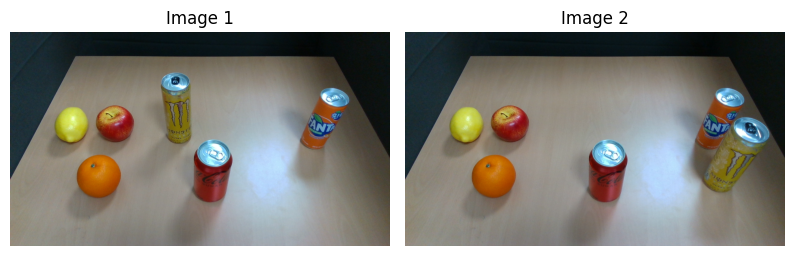

[USER_MSG]


    I will give you <img_2> and <img_3>.
    How did the objects move between the two images? start from the <img_2> into <img_3>?
    only using the following object names: ['apple', 'lemon', 'orange', 'coke', 'monster_drink', 'fanta_orange'].
    action set: [move_object_in_front_of, move_object_to_the_left_of, move_object_to_the_right_of, move_object_behind]
    Answer Format:
    - description: <source_object> <action> <target_object>
    # Only one action happened between the two images.
    


[GPT_OUTPUT]

- description: monster_drink move_object_to_the_right_of coke
41
Error: Expecting value: line 1 column 1 (char 0)


DETAIL: high

[0/2] image_path: ../dataset/household/type/4/3.png
[1/2] image_path: ../dataset/household/type/4/4.png


[VISUALIZE]

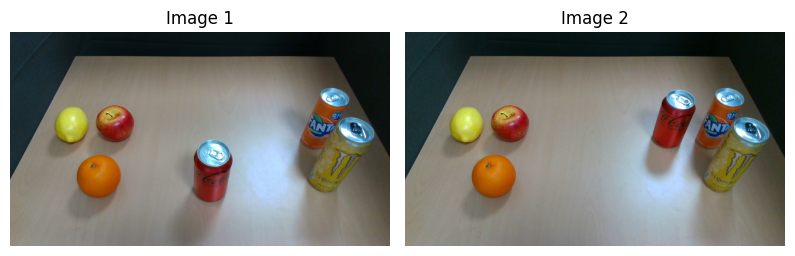

[USER_MSG]


    I will give you <img_3> and <img_4>.
    How did the objects move between the two images? start from the <img_3> into <img_4>?
    only using the following object names: ['apple', 'lemon', 'orange', 'coke', 'monster_drink', 'fanta_orange'].
    action set: [move_object_in_front_of, move_object_to_the_left_of, move_object_to_the_right_of, move_object_behind]
    Answer Format:
    - description: <source_object> <action> <target_object>
    # Only one action happened between the two images.
    


[GPT_OUTPUT]

- description: coke move_object_to_the_right_of apple
41
Error: Expecting value: line 1 column 1 (char 0)


DETAIL: high

[0/4] image_path: ../dataset/household/type/4/1.png
[1/4] image_path: ../dataset/household/type/4/2.png
[2/4] image_path: ../dataset/household/type/4/3.png
[3/4] image_path: ../dataset/household/type/4/4.png


[VISUALIZE]

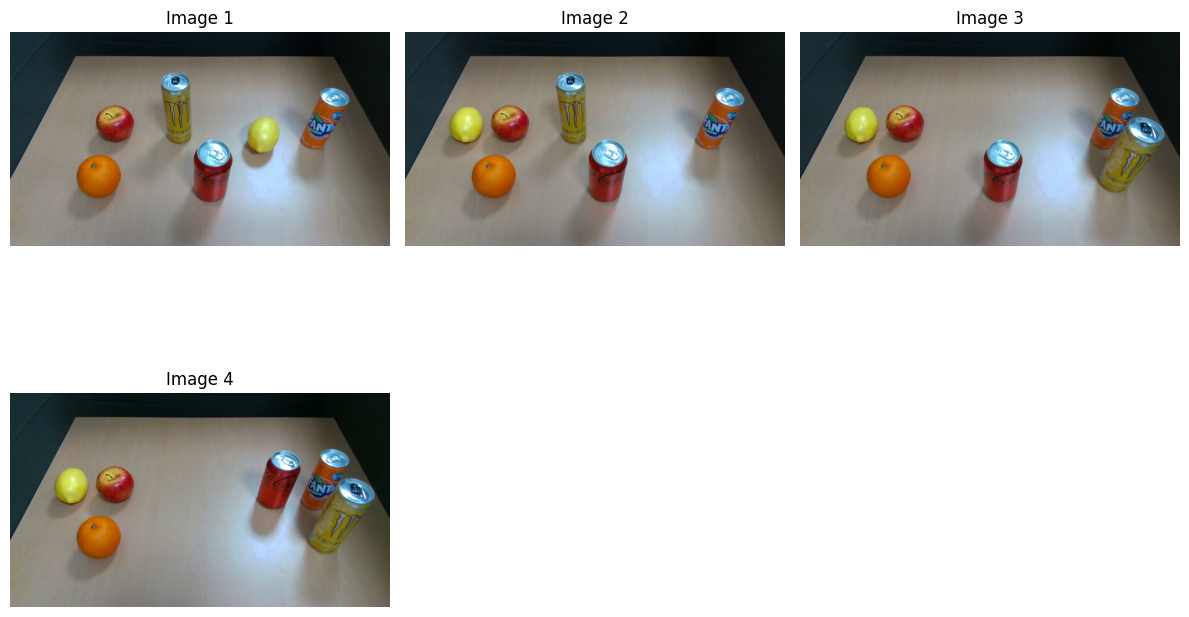

[USER_MSG]


What is the user's preference?

REMEMBER: Please remeber that the preference more related to the semantic meaning, not the exact precision of placing.
Answer preferences as possible as you can specify the spatial relationship between objects.
Please summarize your answer in less than three sentences based on the images and history interactions.

Format:
{
    "preference": "<Identified preference based on visual analysis>",
    "description": "<description_about_preference>"
}



[GPT_OUTPUT]

{
    "preference": "Symmetry and spacing",
    "description": "The user seems to prefer arranging objects symmetrically and with even spacing between them on the surface, as indicated by the consistent positioning of the apple, lemon, orange, and drinks in a line with equal spacing."
}


Total token used: 3157

3157


In [3]:
#%%
# 1. Start with Image description
"""
    You need to check your OpenAI API key.
"""
key_path = '../key/rilab_key.txt'
model = GPT4VisionClass(key_path=key_path, max_tokens=1024, temperature=0.9,
    gpt_model="gpt-4-vision-preview",
    role_msg="You are a helpful agent with vision capabilities; do not respond to objects not depicted in images."
    )

# 2. System prompt: functions, object_names
print("\033[94m [System prompt: infrom the format of the answer] \033[0m")

interaction_accuracy_list = []
preference_list = []
token_list = []
image_token_list = []
response_error_count = 0

#%%
# objective = 'color/2/'
# objective = 'shape/2/'
# objective = 'type/4/'
objective = 'type/4/'
# objective = 'quadrant/1/'
# objective = 'horizontal/1/'
# objective = 'vertical/1/'
dataset_path = '../dataset/household/'
path = os.path.join(dataset_path, objective)
only_img_path = [f for f in os.listdir(path) if f.endswith('.png')]
folders = sorted(only_img_path, key=lambda x: int(x.split('.')[0]))
# folders = sorted(os.listdir(path), key=lambda x: int(x.split('.')[0]))
print(folders, len(folders))

images = []
rgb_filenames = [f for f in only_img_path if f.endswith('.png')]
# Sort it with ends_with number
sorted_rgb_filenames = sorted(rgb_filenames, key=extract_number)
for rgb_index, sorted_rgb in enumerate(sorted_rgb_filenames):
    print(os.path.join(path, sorted_rgb))
    path_local = os.path.join(path, sorted_rgb)
    images.append(path_local)

# object_names = ["obj_star_purple", "obj_star_red", "obj_star_blue", 
#                 "obj_triangle_purple", "obj_triangle_red", "obj_triangle_blue"]
# object_names = ["Hershey", "Oreo", "Pringles", "Starbucks_drink", "Redbull", "Coke"]
object_names = ["apple", "lemon", "orange", "coke", "monster_drink", "fanta_orange"]
# object_names = ["Starbucks_drink", "Coke", "Monster_drink", "Fanta_orange", "Redbull"]
# object_names = ["oreo", "redbull", "starbucks_coffee", "coke", "hershey", "pringles"]
# object_names = ["Oreo", "Hershey", "Pringles", "Coke", "Starbucks_coffee", "Monster_drink"]
# object_names = ["oreo", "monster_drink", "starbucks_coffee", "coke", "hershey", "pringles"]

visual_residuals = []
for i in range(0, len(images)-1):
    query_text = f"""
    I will give you <img_{i+1}> and <img_{i+2}>.
    How did the objects move between the two images? start from the <img_{i+1}> into <img_{i+2}>?
    only using the following object names: {object_names}.
    action set: [move_object_in_front_of, move_object_to_the_left_of, move_object_to_the_right_of, move_object_behind]
    Answer Format:
    - description: <source_object> <action> <target_object>
    # Only one action happened between the two images.
    """

    response_interaction = model.chat(query_text=query_text, image_paths=images[i:i+2], images=None,
                                PRINT_USER_MSG=True,
                                PRINT_GPT_OUTPUT=True,
                                RESET_CHAT=False,
                                RETURN_RESPONSE=True,
                                VISUALIZE=True,
                                DETAIL='high')
    visual_residual, error_message = response_to_json(response_interaction)
    visual_residuals.append(visual_residual)
    if len(error_message) != 0:
        response_error_count += 1
        print(len(error_message))
        print(f"Error: {error_message}")
        continue
    print("Response success!")


######## Preference Reasoning ########
query_text = f"""
What is the user's preference?

REMEMBER: Please remeber that the preference more related to the semantic meaning, not the exact precision of placing.
Answer preferences as possible as you can specify the spatial relationship between objects.
Please summarize your answer in less than three sentences based on the images and history interactions.

Format:
{{
    "preference": "<Identified preference based on visual analysis>",
    "description": "<description_about_preference>"
}}
"""
response_preference = model.chat(query_text=query_text, image_paths=images, images=None,
                            PRINT_USER_MSG=True,
                            PRINT_GPT_OUTPUT=True,
                            RESET_CHAT=False,
                            RETURN_RESPONSE=True,
                            VISUALIZE=True,
                            DETAIL='high')
preference_json, error_message = response_to_json(response_preference)
preference_list.append(response_preference)

print(model.get_total_token())

In [6]:
res_ = np.array([6/9,2/12, 3/9, 2/9, 0/12, 4/12, 3/12])
res_.mean(), res_.std()

(0.28174603174603174, 0.18923204789787879)